In [5]:
# All the imports

import sys
import tweepy
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import re
import string
import math
import preprocessor as p
import string

In [2]:
# Api details and constants

DELHI_WOE_ID = 20070458
consumer_key = ""
consumer_secret = ""
access_key = ""
access_secret = ""


In [3]:
# Basic tweepy api setup

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_key, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)


In [ ]:
# scrape top 50 trends 
def find_trends():
    delhi_trends = api.trends_place(DELHI_WOE_ID)
    trends = json.loads(json.dumps(delhi_trends, indent=1))

    filename = "trends_"+ datetime.today().strftime('%Y_%m_%d_%H_%M_%S')+'.txt'
    f = open(filename, 'w')
    for trend in trends[0]["trends"]:
        f.write(str(trend["name"])+"\n")
    f.close()


In [2]:
# extraction code

def extractTweets(count_val=100):
    fn = input('Enter csv file name to store scraped data : ')
    csvFile = open(fn, 'a')
    csvWriter = csv.writer(csvFile)
    # new_search = search_words
    # trends = fn.readlines()
    L = fn1.readlines()
    csvWriter.writerow(["timestamp", "text", "username", "location",
                        "following", "followers", "about", "lang", "likes", "retweets"])
    for new_search in L:
        print("Searching ", new_search.split('\n')[0])
        for tweet in tweepy.Cursor(api.search, q=new_search.split('\n')[0], count=count_val,
                                since_id=0, id=DELHI_WOE_ID).items():
            print(tweet)
            csvWriter.writerow([tweet.created_at, tweet.text.encode(
                'utf-8'), tweet.user.screen_name.encode('utf-8'), tweet.user.location.encode('utf-8'), tweet.user.friends_count, tweet.user.followers_count,                tweet.user.description.encode('utf-8'), tweet.lang, tweet.favorite_count, tweet.retweet_count])



In [6]:
# data scraping and analysis

Dictionary = []
fn = input('Enter filename : ')
# fileData = open(fn, 'r')
counter = 0
with open(fn, 'r') as data:
    for line in csv.DictReader(data):
        line['username'] = line['username'].split('b\'')[-1]
        Dictionary.append(line)

print('total data', len(Dictionary))


total data 10259


location Analysis of tweets
141


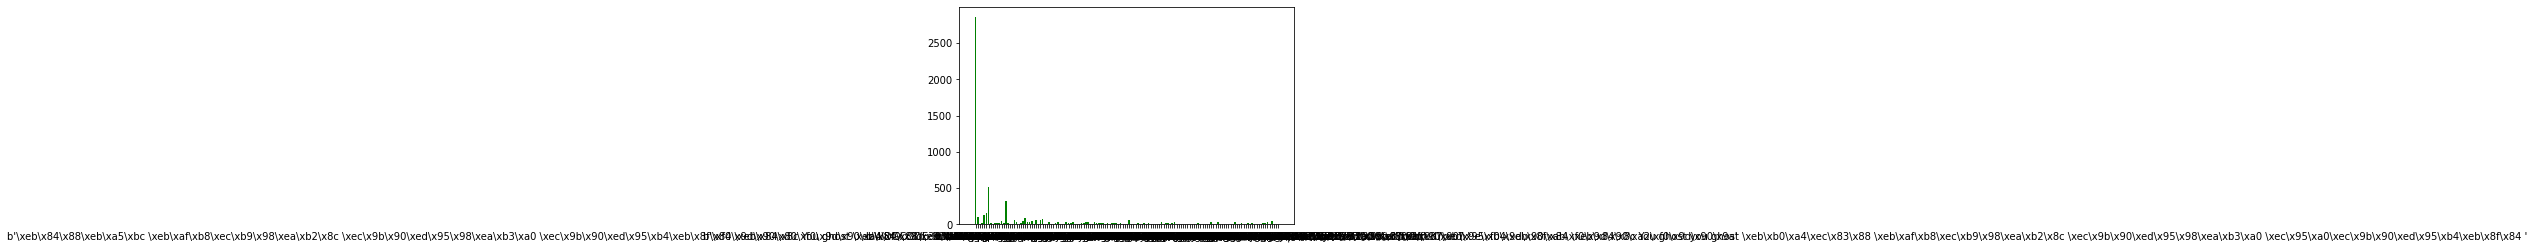

In [9]:
# Location analysis
Lo_names = []
Lo_color = []
Lo_no = []
location = {}
trimmedDict = {}
for i in Dictionary:
    if i['location'] not in location:
        location[i['location']] = 0
    location[i['location']] += 1

sorted(location.items(),key=lambda x:x[1],reverse=True)

print('location Analysis of tweets')
col = ['red', 'green', 'blue', 'cyan', 'orange', 'brown', 'pink']
ind = 0
for i in location.keys():
    Lo_names.append(i)
    Lo_no.append(location[i])
    Lo_color.append(col[ind % 7])
    ind += 1
    if ind>=7:
        break
print(len(location))

plt.bar(location.keys(),location.values(),color='g')
plt.show()

Language Analysis of tweets


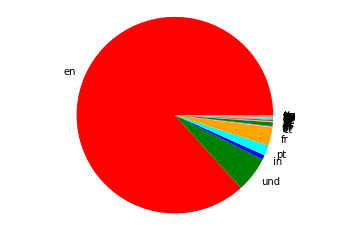

In [5]:
# Language analysis

lang = {}
L_no = []
L_names = []
L_color = []
for i in Dictionary:
    if i['lang'] not in lang:
        lang[i['lang']] = 0
    lang[i['lang']] += 1
print('Language Analysis of tweets')
col = ['red', 'green', 'blue', 'cyan', 'orange', 'brown', 'pink']
ind = 0
for i in lang.keys():
    L_names.append(i)
    L_no.append(lang[i])
    L_color.append(col[ind % 7])
    ind += 1

plt.pie(L_no,labels=L_names,colors=L_color)
plt.axis('equal')
plt.show()


Follow Data
Mean : 10255.592828224408 Variance : 100773248751.31136 Standard-Deviation : 317448.0252754951


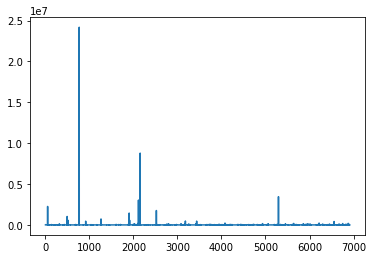

In [11]:
# Followers Analysis

FF_data = {}
for i in Dictionary:
    FF_data[i['username']] = {'following': i['following'],
                              'followers': i['followers'], 'likes': i['likes'], 'retweets': i['retweets']}

print("Follow Data")

tot = 0
x_sum = 0
x_2_sum = 0
trendData = []
for i in FF_data.keys():
    trendData.append(int(FF_data[i]['followers'])-(int(FF_data[i]['followers'])%20))
    x_sum+=int(FF_data[i]['followers'])
    x_2_sum+=int(FF_data[i]['followers'])**2
    tot+=1

x_sum/=tot
x_2_sum/=tot
print('Mean :',x_sum,'Variance :',(x_2_sum-x_sum**2),'Standard-Deviation :',(x_2_sum-x_sum**2)**0.5)
plt.plot(trendData)
plt.show()


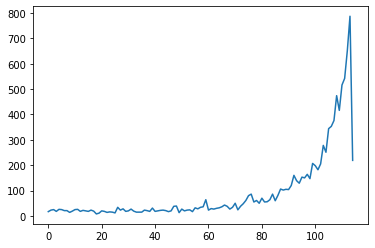

In [5]:
# time analysis
# number of tweets per 5 mins time interval

X = []
freq = []
timeDict = {}
for i in Dictionary:
    tempList = re.split(' |-|:',i['timestamp'])
    for i in range(len(tempList)): 
        tempList[i] = int(tempList[i])
    key = int(math.floor(tempList[-2]/5)+100*tempList[-3]+10000*tempList[-4])
    if key not in timeDict:
        timeDict[key] = 0
    timeDict[key] += 1

z = 0
for i in timeDict.keys():
    X.append(z)
    freq.append(timeDict[i])
    z+=1

plt.plot(X,freq)
plt.show()
    

In [6]:
# bot analyser


W_FC = 0.30

def detectBots(screen_name):
    probBot = 0
    user = api.get_user(screen_name)

    '''
        probBot += w_fc * (100/log(Follower_count,4)) /// w_fc is weight of follwer_count  [30 %]
        
        FOR likes, we can use ( number of likes + number of retweets ) / number of tweets as a potential sign for a bot
        [10]*(number of likes + number of retweets + 1)/(number of tweets + 1)   Special case for no retweets
        
        Language independence implies more bot-like nature [multi-lingual tweets more equi-distributed]


    
        humans have non-zero length of description  [done]
        humans usually have urls in description     [done]


        [Advanced]
        lists/ moments etc. absent is a slight indicator of bots (less weighted)    
        skewed distributed tweet on timeline is a significant indicator of bots
        check time-zone of tweeting anything. If randomly distributed than high prob of it being a bot.
    
    '''
    probBot += W_FC*(100/math.log(user.followers_count, 10))
    probBot += 10*(user.favourites_count/user.statuses_count)
    
    if len(str(user.description)) == 0:
        probBot += 10
    # if len(user.url) == 0:
    #     probBot += 3
    
    return probBot

while True:
    usern = input('Enter username : (\'-\' to exit')
    if usern == '-':
        break
    print(detectBots(usern))

